In [4]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import json
from pathlib import Path

sys.path.append(str(Path.cwd()))

from data_utils import prepare_egs_data


In [5]:
regions = gpd.read_file(
    Path.cwd().parent.parent.parent /
    "cluster_data" /
    "old_data" /
    "resources" /
    "regions_onshore_elec_s_72.geojson"
    ).set_crs("EPSG:4326").set_index("name")

In [37]:
prepared_data = prepare_egs_data(Path.cwd().parent / "data" / "egs_costs.json")
for key, item in prepared_data.items():
    prepared_data[key] = item.groupby("geometry").mean().reset_index()

In [7]:
a = prepared_data[2050]
b = prepared_data[2025]
print(b.head())

         CAPEX    HeatSust  PowerSust  \
0  3420.574741    0.000000   0.000000   
1  7191.718059  170.334048   0.076234   
2  7453.440116   85.160392   0.038451   
3  3420.574741    0.000000   0.000000   
4  7737.753049    0.000000   0.000000   

                                            geometry  
0  POLYGON ((10.00000 43.00000, 10.00000 44.00000...  
1  POLYGON ((12.00000 47.00000, 12.00000 48.00000...  
2  POLYGON ((7.00000 50.00000, 7.00000 51.00000, ...  
3  POLYGON ((10.00000 43.00000, 10.00000 44.00000...  
4  POLYGON ((12.00000 41.00000, 12.00000 42.00000...  


In [8]:
print(a.shape, b.shape)
# new = a.loc[a.geometry.isin(b.geometry)]
new = a.loc[(a.HeatSust > 0.) & (a.HeatSust.isin(b.HeatSust))]

print(len(b.geometry.unique()))
print(len(new.geometry.unique()))

g = new.geometry.value_counts().index[1]
# geom = 

(739, 4) (40, 4)
30
22


In [9]:
print((p := prepared_data[2050]).loc[p.geometry == g])
print((p := prepared_data[2045]).loc[p.geometry == g])

print((p := prepared_data[2045]).loc[p.geometry == g].groupby("geometry").mean().reset_index())
print((p := prepared_data[2050]).loc[p.geometry == g].groupby("geometry").mean().reset_index())

           CAPEX    HeatSust  PowerSust  \
7    2183.550547  170.334048   0.076234   
98   2183.550547  170.334048   0.076234   
414  2183.550547  170.334048   0.076234   

                                              geometry  
7    POLYGON ((12.00000 47.00000, 12.00000 48.00000...  
98   POLYGON ((12.00000 47.00000, 12.00000 48.00000...  
414  POLYGON ((12.00000 47.00000, 12.00000 48.00000...  
           CAPEX    HeatSust  PowerSust  \
4    2487.601889  170.334048   0.076234   
67   2487.601889  170.334048   0.076234   
294  2487.601889  170.334048   0.076234   

                                              geometry  
4    POLYGON ((12.00000 47.00000, 12.00000 48.00000...  
67   POLYGON ((12.00000 47.00000, 12.00000 48.00000...  
294  POLYGON ((12.00000 47.00000, 12.00000 48.00000...  
                                            geometry        CAPEX    HeatSust  \
0  POLYGON ((12.00000 47.00000, 12.00000 48.00000...  2487.601889  170.334048   

   PowerSust  
0   0.076234  
     

In [10]:
import seaborn as sns

df = pd.DataFrame(columns=prepared_data.keys())

for year in df.columns:

    year_data = prepared_data[year].groupby("geometry").mean().reset_index()

    for g in year_data.geometry:

        if not g in year_data.geometry.tolist():
            continue
        df.loc[g, year] = year_data.loc[year_data.geometry == g, "CAPEX"].values[0]

print(df)



                                                           2015          2020  \
POLYGON ((10 43, 10 44, 11 44, 11 43, 10 43))       6747.411806   4585.425126   
POLYGON ((-22 64, -22 65, -21 65, -21 64, -22 64))          NaN    8202.42596   
POLYGON ((-23 65, -23 66, -22 66, -22 65, -23 65))          NaN  11233.624429   
POLYGON ((-22 65, -22 66, -21 66, -21 65, -22 65))          NaN   9286.597414   
POLYGON ((-21 64, -21 65, -20 65, -20 64, -21 64))          NaN   6083.625666   
...                                                         ...           ...   
POLYGON ((16 46, 16 47, 17 47, 17 46, 16 46))               NaN           NaN   
POLYGON ((15 46, 15 47, 16 47, 16 46, 15 46))               NaN           NaN   
POLYGON ((9 44, 9 45, 10 45, 10 44, 9 44))                  NaN           NaN   
POLYGON ((22 41, 22 42, 23 42, 23 41, 22 41))               NaN           NaN   
POLYGON ((22 38, 22 39, 23 39, 23 38, 22 38))               NaN           NaN   

                           

<AxesSubplot:>

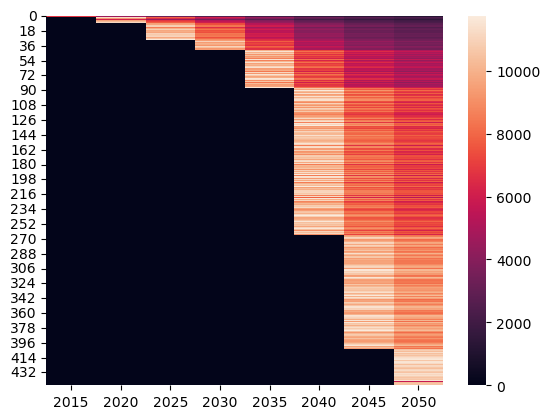

In [11]:
sns.heatmap(df.reset_index().drop("index", axis=1).fillna(0))

In [12]:
from itertools import product

def polyfit2d(x, y, z, order=3):
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = product(range(order+1), range(order+1))
    for k, (i,j) in enumerate(ij):
        G[:,k] = x**i * y**j
    m, _, _, _ = np.linalg.lstsq(G, z)
    return m

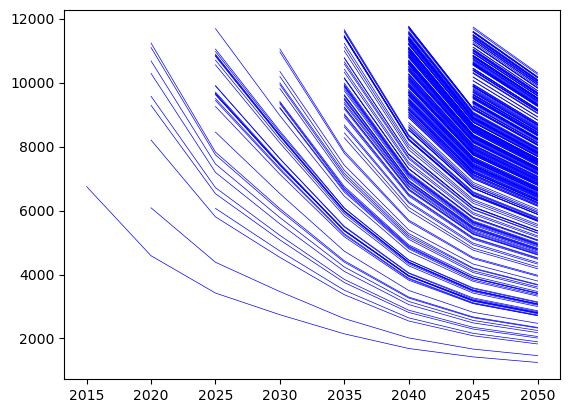

In [13]:
fig, ax = plt.subplots()

for i, row in df.iterrows():
    ax.plot(row.index, row.values, linewidth=0.5, color="b")

plt.show()

X = list()
y = list()

for i, row in df.iloc[:,::-1].iterrows():
    row = row.loc[row.notna()]

    for j, value in enumerate(row.values):

        if j == len(row) - 1:
            break

        X.append([value, row.index[j]])
        y.append(row.values[j+1])

X = np.array(X)
y = np.array(y)

In [70]:
factor_mean = pd.Series(index=np.unique(X[:,1]).astype(int)).sort_index()
factor_std = pd.Series(index=np.unique(X[:,1]).astype(int)).sort_index()

for year in factor_mean.index:

    mask = X[:,1] == year

    factor_mean.loc[year] = (y[mask] / X[mask, 0]).mean()
    factor_std.loc[year] = (y[mask] / X[mask, 0]).std()

# factor_mean.drop(2015, inplace=True)
# factor_std.drop(2015, inplace=True)

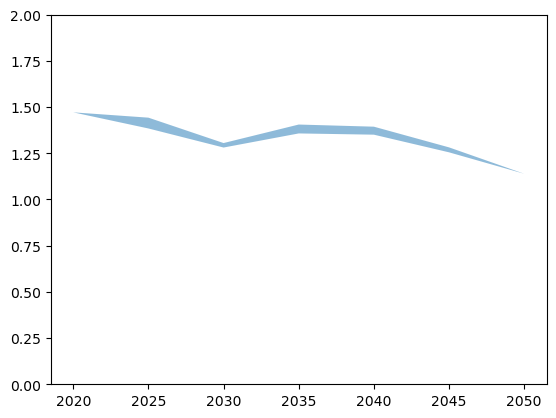

In [94]:
fig, ax = plt.subplots()

ax.fill_between(factor_mean.index, factor_mean - factor_std, factor_mean + factor_std, alpha=0.5)

ax.set_ylim(0, 2)
plt.show()

In [102]:
geom = prepared_data[2040].geometry.iloc[0]

prepared_data[2040].loc[prepared_data[2040].geometry.isin([geom])]

def prepare_capex():

    capex = pd.DataFrame(index=prepared_data[2050].geometry, columns=prepared_data.keys())

    capex.loc[:, 2050] = prepared_data[2050]["CAPEX"]
    for sooner, later in zip(capex.columns[::-1][1:], capex.columns[::-1]):

        p = prepared_data[sooner]

        capex.loc[p.geometry, sooner] = p["CAPEX"]
        missing_idx = capex.loc[capex[sooner].isna()].index

        from_later = (
            capex[later]
            .loc[missing_idx]
        )

        capex.loc[missing_idx, [sooner]] = from_later * factor_mean.loc[later]

    capacity_factor = 0.9
    orc_cost = 1900 # USD/kW
    efficiency = 0.12

    for year in capex.columns[1:]:

        orc_cost /= factor_mean.loc[year]
        capex.loc[:, year] = capex[year] - orc_cost

    capex = capex / capacity_factor * efficiency
    
    return capex


In [153]:
capex = prepare_capex()

In [159]:
import warnings
warnings.filterwarnings("ignore")

as_regions = pd.DataFrame()

p = gpd.GeoDataFrame(capex[[2050]].reset_index().rename(columns={2050: "CAPEX"}), crs="EPSG:4326")
capexes_mean = list()
capexes_min = list()

for i, (region, row) in enumerate(regions.iterrows()):

    overlap = p.loc[p.geometry.intersects(row.geometry)]
    shares = (a := overlap.geometry.intersection(row.geometry).area) / a.sum()

    capexes_mean.append(shares.multiply(overlap["CAPEX"]).sum() or np.nan)
    capexes_min.append(overlap["CAPEX"].min() or np.nan)

regions["capex_mean"] = capexes_mean
regions["capex_min"] = capexes_min

<AxesSubplot:>

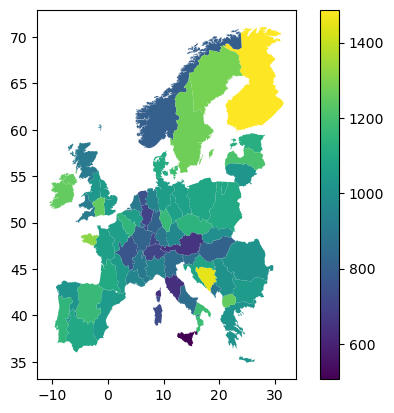

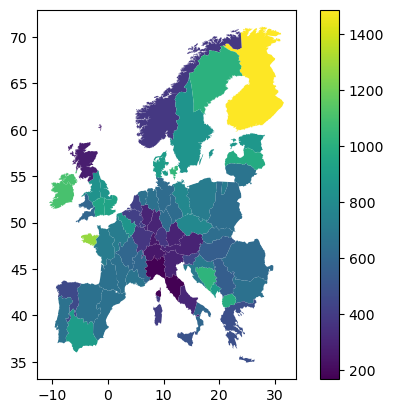

In [160]:
regions.plot(column="capex_mean", legend=True)
regions.plot(column="capex_min", legend=True)

In [152]:
regions.loc[regions.capex_min.isna()]

,geometry,capex,capex_mean,capex_min
name,,,,
AL1 0,"POLYGON ((20.32207 39.91318, 20.39703 39.81809...",NaN,NaN,NaN
ES4 0,"POLYGON ((2.56910 39.53152, 2.52019 39.47285, ...",NaN,NaN,NaN


In [43]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler


x_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(np.atleast_2d(y).T)

# model = linear_model.LinearRegression().fit(scaler.transform(X), y)
model = RandomForestRegressor().fit(
    x_scaler.transform(X),
    y_scaler.transform(np.atleast_2d(y).T).flatten()
    )

def generate_examples():

    n = 100

    year_test = np.random.choice(df.columns, replace=True, size=n)
    capex_test = np.random.uniform(df.min().min(), df.max().max(), size=n)

    X_test = np.vstack([capex_test, year_test]).T

    y_test = model.predict(x_scaler.transform(X_test))
    y_test = y_scaler.inverse_transform(np.atleast_2d(y_test).T).flatten()

    return X_test, y_test

X_test, y_test = generate_examples()

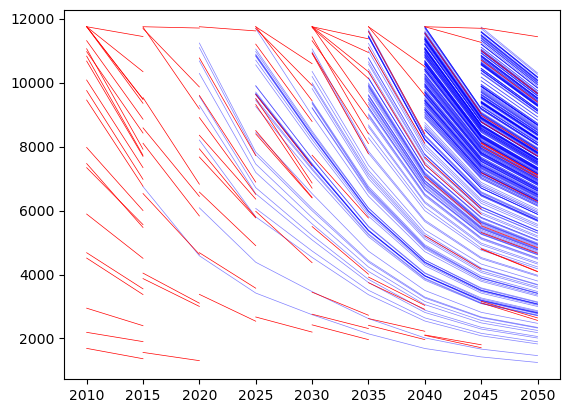

In [109]:
fig, ax = plt.subplots()

for i, row in df.iterrows():
    ax.plot(row.index, row.values, linewidth=0.5, color="b", alpha=0.5)

for xx, yy in zip(X_test, y_test):
    ax.plot([xx[1], xx[1]-5], [xx[0], yy], color="r", linewidth=0.5)

plt.show()

In [118]:
from scipy.optimize import minimize


def mapper(a, b, year, capex):
    return capex + a * np.exp(b*(1 - year))

def error(params, X, y):

    cost_fun = 0

    for (capex, year), yy in zip(X, y):
        cost_fun += (mapper(*(params.tolist() + [year, capex])) - yy)**2
    return cost_fun


data = (
    x_scaler.transform(X),
    y_scaler.transform(np.atleast_2d(y).T).flatten()
)

a, b = minimize(error, (0.1, 0.1), args=data).x

In [129]:
y = list()

for xx in x_scaler.transform(X_test):
    y.append(mapper(a, b, xx[1], xx[0]))

y = y_scaler.inverse_transform(np.atleast_2d(y).T).flatten()

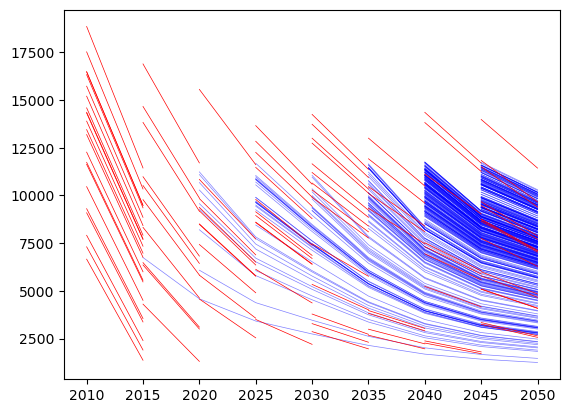

In [133]:
fig, ax = plt.subplots()

for i, row in df.iterrows():
    ax.plot(row.index, row.values, linewidth=0.5, color="b", alpha=0.5)

for i, (xx, new_y) in enumerate(zip(X_test, y)):

    # print(xx)
    # print(new_y)

    ax.plot([xx[1], xx[1]-5], [xx[0], new_y], color="r", linewidth=0.5)

plt.show()

In [1]:
prepared_data

NameError: name 'prepared_data' is not defined

In [178]:
import os
import pypsa
import pandas as pd
import numpy as np

from pathlib import Path
import matplotlib.pyplot as plt

base = Path.cwd().parent.parent.parent / "cluster_data" / "dump"
n = pypsa.Network(base / 'elec_s_72_lv1.0__Co2L0-180H-T-H-B-I-solar+p3-dist1_2050_2045_dh_static_0.3_True.nc')

INFO:pypsa.io:Imported network elec_s_72_lv1.0__Co2L0-180H-T-H-B-I-solar+p3-dist1_2050_2045_dh_static_0.3_True.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


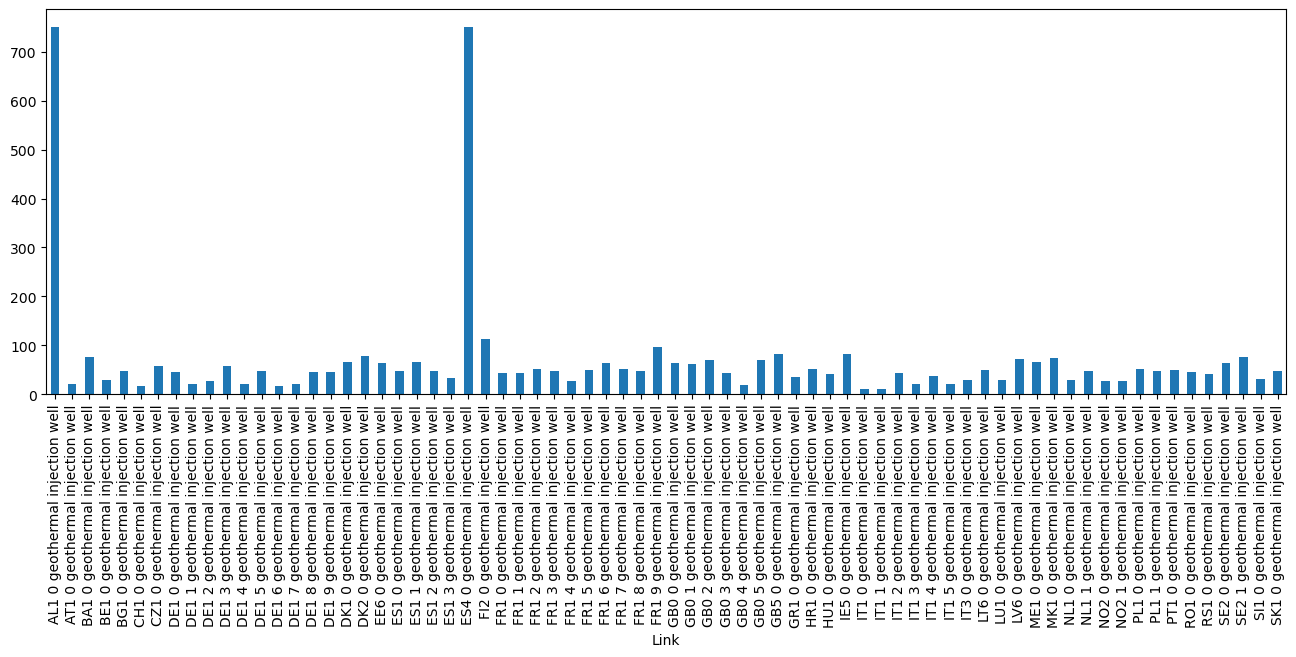

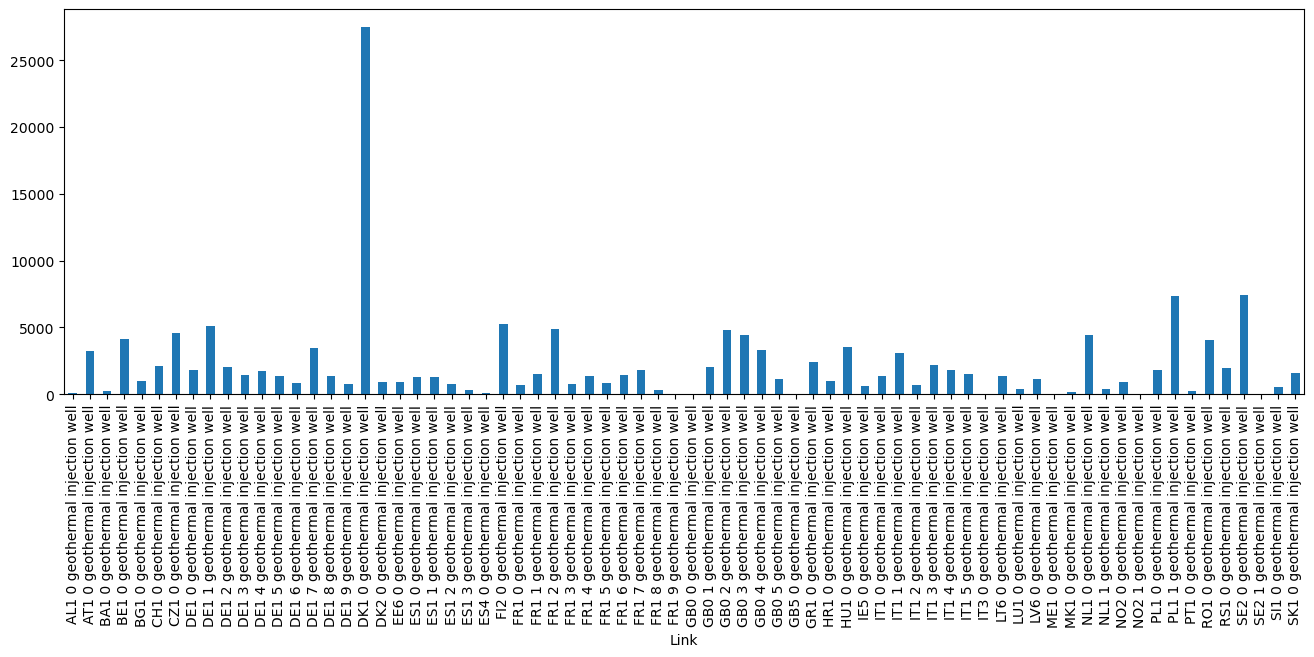

(0.0, 100.0)

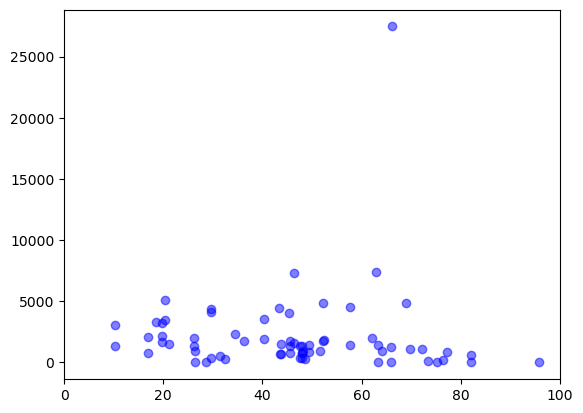

In [179]:
fig, ax = plt.subplots(figsize=(16, 5))
n.links.loc[n.links.carrier == "injection geothermal heat", "capital_cost"].plot.bar(ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(16, 5))
n.links.loc[n.links.carrier == "injection geothermal heat", "p_nom_opt"].plot.bar(ax=ax)
plt.show()

plt.scatter(
    n.links.loc[n.links.carrier == "injection geothermal heat", "capital_cost"].values,
    n.links.loc[n.links.carrier == "injection geothermal heat", "p_nom_opt"].values,
    color="b",
    alpha=0.5,
)
plt.xlim(0,100)